# RuLSIFでの重み付け
*Relative unconstrained least-squares importance fitting*の略。重みをカーネル関数の足し合わせ(係数未知)として、この係数を真の相対重要度（密度比）との２乗誤差を最小化するという学習基準に基づいて学習する。二乗誤差を学習基準にすることで、ロバストな重み付が学習できるそう(杉山先生の資料(2013)より)

実装は[こちら](http://allmodelsarewrong.org/RuLSIF.html)を拝借している

密度比推定の論文は、求めているものは密度比$\frac{p_{test}(x)}{p_{train}(x)}$になるので, entropy estimatorでの重みの総和1制約のようなものは存在しない

### コードの追試（2次元での密度比推定）

In [45]:
from pyRULSIF import *
from pylab import *

In [50]:
np.random.seed(123)
x = np.random.multivariate_normal(mean = [0,0], cov = [[1,0],[0,1]], size = 300)
y = np.random.multivariate_normal(mean = [1.5,1.5], cov = [[1,0],[0,1]], size = 100)

In [51]:
x_re_2d = np.concatenate((np.linspace(-4,4,500)[:,np.newaxis], np.linspace(-4,4,500)[:,np.newaxis]), axis = 1)

In [52]:
PE, w, s = R_ULSIF(y.T, x.T, c_[x_re_2d.T, y.T, x.T], alpha,
                   sigma_list(x_nu, x_de), lambda_list(), x_nu.shape[1], 5)

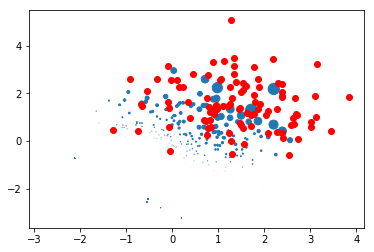

In [53]:
plt.scatter(x[:,0], x[:,1],  s = w[600:900]*10)
plt.plot(y[:,0], y[:,1], 'ro')

いけますた

# 一次元タスクでのRuLSIFとMCEWの比較

## 元データ生成
No Bias Left Behind: Covariate Shift Adaptation for Discriminative 3D Pose Estimationでのtoy practiceでの設定

In [119]:
import autopep8
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import itertools as it
import numpy as np
from scipy.spatial import distance
%matplotlib inline

In [6]:
def gen_x(y):
    return y + 0.3 * np.sin(2*np.pi*y) + np.random.normal(loc=0.0, scale=0.05, size=len(y))

In [193]:
np.random.seed(123)
# data size setting
data_size_train = 400
data_size_test = 200

# generate train /test data
test_y = np.concatenate((np.random.normal(0.9, scale=0.025, size=int(data_size_test/2)),
                         np.random.normal(0.1, scale=0.025, size=int(data_size_test/2))))
test_x = gen_x(test_y)
X = np.linspace(-0.5, 1.0, 500)

train_y = np.random.normal(0.5, 0.22,size=data_size_train)
train_x = gen_x(train_y)

Text(0,0.5,'y')

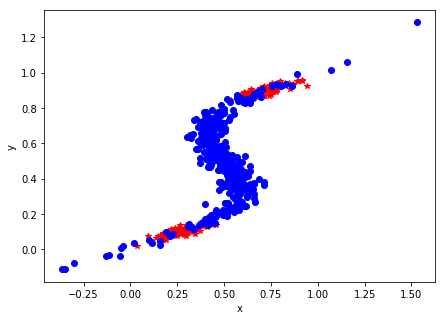

In [194]:
plt.figure(figsize=(7, 5))
plt.plot(test_x, test_y, 'r*', label='test')
plt.plot(train_x, train_y, 'bo', label='train')
plt.xlabel('x')
plt.ylabel('y')

(array([ 5., 19., 52., 16.,  8.,  2., 25., 45., 20.,  8.]),
 array([0.03499563, 0.12563513, 0.21627463, 0.30691412, 0.39755362,
        0.48819312, 0.57883262, 0.66947212, 0.76011161, 0.85075111,
        0.94139061]),
 <a list of 10 Patch objects>)

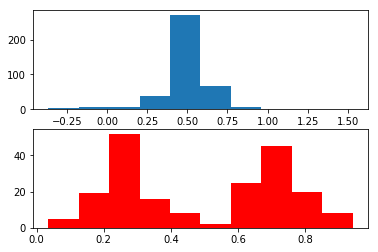

In [195]:
plt.subplot(2,1,1)
plt.hist(train_x)
plt.subplot(2,1,2)
plt.hist(test_x, color = 'r')

(array([77., 23.,  0.,  0.,  0.,  0.,  0.,  0.,  8., 92.]),
 array([0.01922362, 0.11328218, 0.20734073, 0.30139928, 0.39545783,
        0.48951638, 0.58357493, 0.67763348, 0.77169203, 0.86575058,
        0.95980913]),
 <a list of 10 Patch objects>)

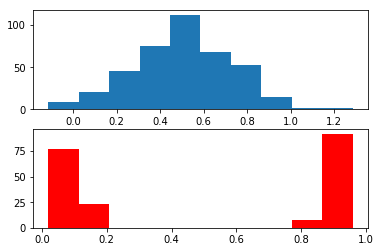

In [196]:
plt.subplot(2,1,1)
plt.hist(train_y)
plt.subplot(2,1,2)
plt.hist(test_y, color = 'r')

## 2 Kernel regresson

***カーネル回帰モデル***

$f(x;A) = A^Tk(x)$

で表される。この時、
$k(x)=[1, K(x,x_1^{tr}), K(x,x_2^{tr}), \cdots K(x, x_{n_{tr}}^{tr})]^T$の場合、

モデルパラメータ$A$は、

$ \hat{A}= (\tilde{K}^{tr}W(\tilde{K}^{tr})^T+\gamma I)\tilde{K}^{tr}W(Y^{tr})^T $

で解析的に求まる。ここで、

$\tilde{K}^{tr}=[k(x_1^{tr}), k(x_2^{tr}), \cdots,k(x_{n_{tr}}^{tr})], Y^{tr}=[y_1^{tr}, \cdots, y_{n_{tr}}^{tr}]$である

# sklearnでsample_weight考慮モデルあり ・・・

In [197]:
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression

In [198]:
grid = np.linspace(0,1,100)[:,np.newaxis].T

In [199]:
train_x = train_x.reshape(-1,1)
X = X.reshape(-1, 1)

kx = rbf_kernel(train_x, train_x)
KX = rbf_kernel(X, train_x)

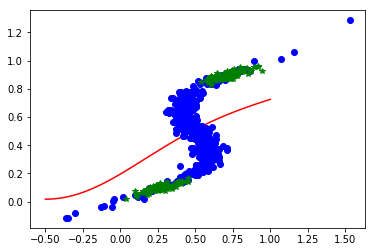

In [200]:
clf = Ridge()
clf.fit(kx, train_y)
plt.plot(X, clf.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

In [201]:
kx_test = rbf_kernel(test_x.reshape(-1,1), train_x)
print('rmse:', np.sqrt((clf.predict(kx_test) - test_y)**2).mean())

rmse: 0.2757834365046266


## RuLSIFによる重み付け

### $\alpha = 0$

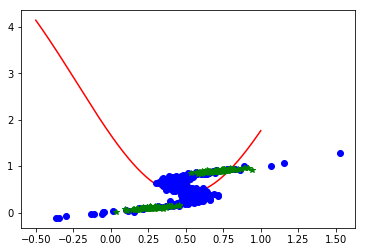

In [202]:
alpha = 0
PE, lsif_w, s = R_ULSIF(test_x[:,np.newaxis].T, train_x.T, c_[grid, test_x[:, np.newaxis].T, train_x.T], alpha,
                   sigma_list(test_x[:, np.newaxis].T, train_x.T), lambda_list(), len(test), 5)

clf_lsif = Ridge()
clf_lsif.fit(kx, train_y, sample_weight = lsif_w[-len(train_x):])

plt.plot(X, clf_lsif.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

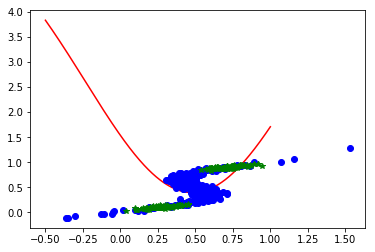

In [203]:
alpha = 0.3
PE, lsif_w, s = R_ULSIF(test_x[:,np.newaxis].T, train_x.T, c_[grid, test_x[:, np.newaxis].T, train_x.T], alpha,
                   sigma_list(test_x[:, np.newaxis].T, train_x.T), lambda_list(), len(test), 5)

clf_lsif = Ridge()
clf_lsif.fit(kx, train_y, sample_weight = lsif_w[-len(train_x):])

plt.plot(X, clf_lsif.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

### $\alpha = 0.5$

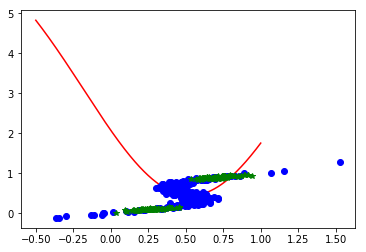

In [204]:
alpha = 0.5
PE, lsif_w, s = R_ULSIF(test_x[:,np.newaxis].T, train_x.T, c_[grid, test_x[:, np.newaxis].T, train_x.T], alpha,
                   sigma_list(test_x[:, np.newaxis].T, train_x.T), lambda_list(), len(test), 5)

clf_lsif = Ridge()
clf_lsif.fit(kx, train_y, sample_weight = lsif_w[-len(train_x):])

plt.plot(X, clf_lsif.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

### $\alpha = 1$

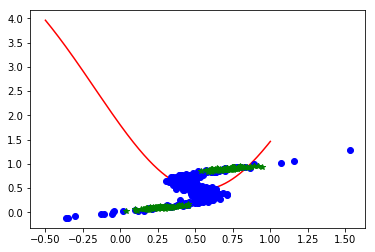

In [205]:
alpha = 1
PE, lsif_w, s = R_ULSIF(test_x[:,np.newaxis].T, train_x.T, c_[grid, test_x[:, np.newaxis].T, train_x.T], alpha,
                   sigma_list(test_x[:, np.newaxis].T, train_x.T), lambda_list(), len(test), 5)

clf_lsif = Ridge()
clf_lsif.fit(kx, train_y, sample_weight = lsif_w[-len(train_x):])

plt.plot(X, clf_lsif.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

In [211]:
print('rmse:', np.sqrt((clf_lsif.predict(kx_test) - test_y)**2).mean())

rmse: 0.5109956941435922


## MCEWによる重み付け

In [215]:
def cal_MCEW(train, test):
    # train, test ndarray object number of data(row) × n-dim(column)
    grad = np.log(distance.cdist(train,test)).sum(axis = 1) 
    grad = grad/grad.sum()
    weight = 1 - 1 / grad.max() * grad
    return(weight / weight.sum())

MCE_w = cal_MCEW(train_x*100, test_x[:, np.newaxis]*100)

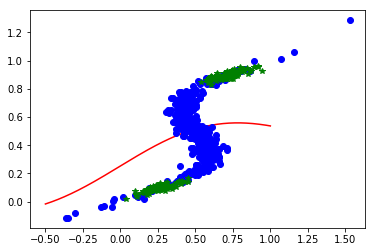

In [216]:
clf_mce = Ridge()
clf_mce.fit(kx, train_y, sample_weight = MCE_w[-len(train_x):]*len(train_x))

plt.plot(X, clf_mce.predict(KX), 'r-')
plt.plot(train_x, train_y, 'bo')
plt.plot(test_x, test_y, 'g*')

In [217]:
kx_test = rbf_kernel(test_x.reshape(-1,1), train_x)
print('rmse:', np.sqrt((clf.predict(kx_test) - test_y)**2).mean())
print('rmse:', np.sqrt((clf_mce.predict(kx_test) - test_y)**2).mean())

rmse: 0.2757834365046266
rmse: 0.33035909660112706
